# Chapter 3. Classification 

## Setting

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## MNIST DATA DOWNLOAD

In [3]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

Could not download MNIST data from mldata.org, trying alternative...
Success!


In [4]:
mnist
X = mnist['data']
y = mnist['target']

In [52]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
some_digit = X_train[36000]

In [6]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [7]:
#Binary Classifier 만들어보자 
y_train_5 = (y_train == 5) #Boolean 으로 만든거
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [8]:
sgd_clf.predict([X_train[1000]])

array([False], dtype=bool)

## Mearsuring Accurcy using CV

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5): # True, False 갯수로 나누겠네
        clone_clf = clone(sgd_clf)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train_5[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train_5[test_index]
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(n_correct / len(y_pred))
        
# Cross_val_score 함수 쓰는게 훨 편리하네 

from sklearn.model_selection import cross_val_score
cross_val_score = cross_val_score(sgd_clf,X_train, y_train_5, scoring = 'accuracy', cv = 3)

0.9502
0.96565
0.96495


### Cross_val로 정답 확률 구하는 것도 좋지만, 한 쪽으로 class가 치우쳐져 있는 경우가 많아서 
### 이걸로 잘 예측하고 있는 건지 확인하기 어렵다. 그래서 precision이 필요하다. 
* Cross_val_predict : cv = n 으로 나누어서 각각 cv에 대해서 예측한 값 전부 합쳐놓은게 y_train_pred 이다. 
* Precision : TP/(TP + FP) FP : 원래 False인데 True로 잘못  -> a로 예측한 것 중에 진짜 a 비율
* Recall : TP/ (TP + FN) FN : 원래 True인데 False로 잘못 -> 진짜 a 중에 a로 예측한 것 비율
* F1 Score = 1/(1/precision + 1/recall)) 
 * Precision / Recall tradeoff 관계에 있다 둘 중에 어떤 걸 택할 건지는 상황에 맞춰서 선택해야 함

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) 
# False인데 False인거(true negative), False인데 True인거(false positive), True인데 False인거(false negative), True인데 True(true positive) 인거 순서대로 

array([[53272,  1307],
       [ 1077,  4344]])

In [11]:
y_train_pred

array([False, False, False, ..., False, False, False], dtype=bool)

In [12]:
y_train_5

array([False, False, False, ..., False, False, False], dtype=bool)

In [13]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.768713502035
0.801328168235


In [14]:
#F1 Score 도입해서 Precision, Recall 둘에 대해서 판단하고자 함. 
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.784682080925


In [15]:
y_scores = sgd_clf.decision_function([X[36000]])

In [16]:
#Threshold 별로 precision, recall 구하기. 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function') # 어떻게 구한 거지

In [17]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label= 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.ylim([0,1])

### Threshold는 구했는데 이거 어디다 쓰는거지 무슨 의미?

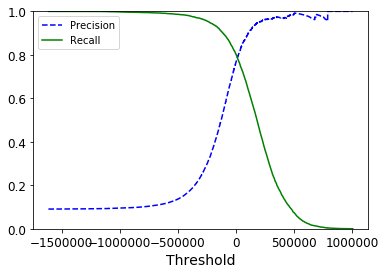

In [19]:
plot_precision_recall_vs_threshold(precisions,recalls, thresholds)
plt.show()

In [23]:
y_train_pred_90 = (y_scores>70000)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.865920511649
0.699317469102


### The ROC Curve
- ROC Curve는 Precision/Recall Curve랑 비슷한 거다. 
- True positive rate(Recall) vs False positive rate(FP/FP+TN, FP 해서 틀린거랑 실제 N 전체의 비율) 비율이다.
- Recall이 높아지면 많은 시도를 하니까 P 골라서 틀릴 확률 증가. 

값이 0이면 Recall이 너무 낮다, 값이 1이면 TPR이랑 FPR이 같다. 

- ROC Curve의 AUC(Area Under the Curve)를 보고 판단하고 주로 좋은 분류기는 1에 가까운 값을 갖는다. 랜덤한게 0.5

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [25]:
fpr.shape

(3435,)

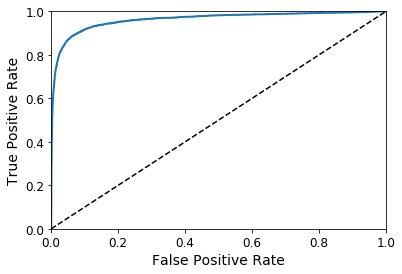

In [26]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96244965559671547

In [39]:
#RandomForest에 대해서 ROC 확인
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 5, method = 'predict_proba')

In [43]:
y_scores_forest = y_probas_forest[:,1]
y_scores_forest
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

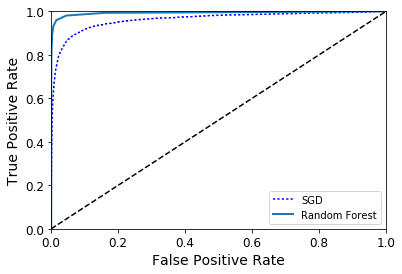

In [45]:
#ROC plotting
plt.plot(fpr, tpr, 'b:', label = 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest') 
plt.legend(loc = 'lower right')
plt.show()

## MultiClassifcation : 두가지 전략 존재 
- OvA(One-versus-All) : 1 vs 나머지로 비교한다. Class수 만큼 비교 
- OvO(One-versus-One) : 하나씩 비교한다. 5개 Class면 총 5+4+3+2+1번 비교 

SVM 제외하고 전부다 OvA 사용하고 있다. 그게 대중적인가 보네 

In [53]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(some_digit)

C:\anaconda\envs\py36\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 5.])

In [57]:
some_digit_scores = sgd_clf.decision_function([some_digit]) #score 구해서 돌려줌
some_digit_scores

array([[ -62703.44639676, -460687.57933386, -319518.34098955,
        -114278.16461143, -468462.8389351 ,   44427.85526221,
        -693906.24797703, -372143.79048941, -536909.69073874,
        -462244.00683201]])

## Error Analysis
- Error 찾는 방법 알려준다.

In [75]:
#전처리
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [76]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv =3)

In [77]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [78]:
conf_mx

array([[5718,    2,   26,    9,   10,   52,   46,   10,   46,    4],
       [   1, 6446,   48,   29,    7,   43,    6,   14,  136,   12],
       [  55,   40, 5301,  105,   80,   31,   92,   59,  179,   16],
       [  42,   41,  142, 5309,    3,  261,   34,   51,  138,  110],
       [  17,   22,   37,    9, 5368,    9,   56,   32,   83,  209],
       [  71,   37,   37,  176,   79, 4631,  103,   24,  158,  105],
       [  28,   21,   44,    2,   46,   94, 5632,    5,   45,    1],
       [  26,   18,   72,   30,   58,   12,    4, 5782,   17,  246],
       [  44,  152,   67,  142,   20,  170,   49,   27, 5026,  154],
       [  39,   30,   27,   89,  158,   31,    2,  199,   76, 5298]])

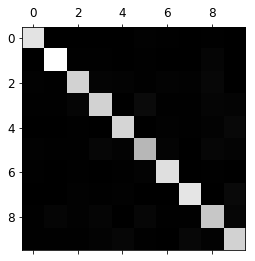

In [80]:
#Confusion matrix로 데이터 확인.
plt.matshow(conf_mx, cmap = plt.cm.gray)

In [82]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)

In [84]:
norm_conf_mx = conf_mx/row_sums

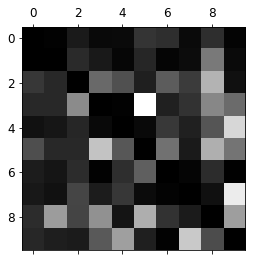

In [86]:
#대각행렬 값 0으로 놓고 보면 어느 항목이 많이 틀린지 알 수 있다. 많을 수록 밝아짐
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

### 많이 틀린 항목을 찾으면 어떻게 개선해야 될 지 알 수 있다. 예를 들면 전처리, Data 더 수집, Augmentation 등

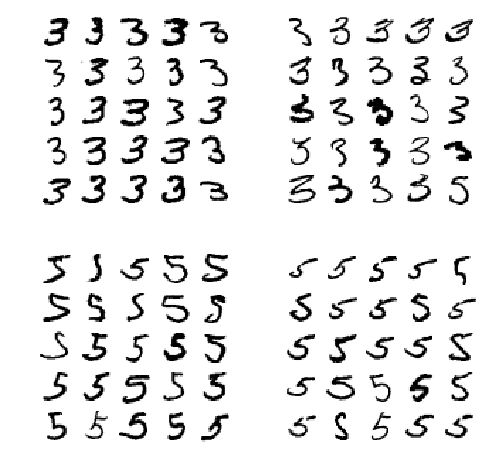

In [92]:
#3, 5가 많이 틀린데, 왜 그런지 확인한다. -> 개선 방안 알 수 있음
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize = (8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)

In [93]:
#multilabeling 하는 것 
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv = 3)

In [ ]:
y_train_knn_pred

In [ ]:
#Knn으로 구한걸로 F1 score 구하기. 
f1_score(y_train, y_train_knn_pred, average = 'macro')